Downloads currency data from YahooFinance, performs monte carlo simuation, calculates delta normal VaR and Expected Shortfall

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as prd
#the following is added to make yf to work:
import yfinance as yf
yf.pdr_override()
#Function to downloads financial data and calculates mean and VarCov matrix ofdaily growth rates
def get_data(assets,start,end):
  data=prd.get_data_yahoo(assets,start,end)
  data=data['Close']
  returns=data.pct_change()
  meanReturns=returns.mean()
  covMatrix=returns.cov()
  return meanReturns, covMatrix

[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed


Ticker
CHFUSD=X    0.000121
EURUSD=X    0.000050
GBPUSD=X    0.000144
dtype: float64 Ticker    CHFUSD=X  EURUSD=X  GBPUSD=X
Ticker                                
CHFUSD=X  0.000019  0.000013  0.000013
EURUSD=X  0.000013  0.000016  0.000014
GBPUSD=X  0.000013  0.000014  0.000019


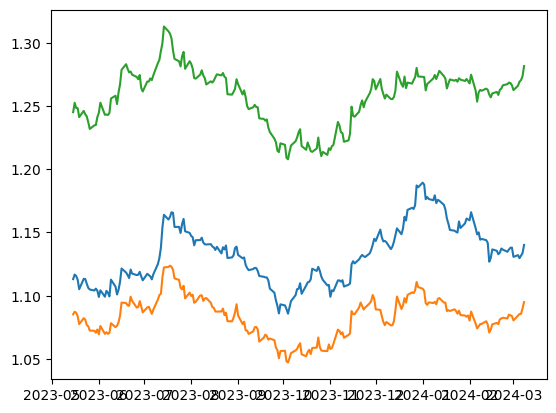

In [2]:
assets=['EURUSD=X','GBPUSD=X',"CHFUSD=X"]
endDate=dt.datetime.now()
startDate=endDate-dt.timedelta(days=300)
meanReturns, covMatrix = get_data(assets,startDate,endDate)
#Visual check of data and its statistics
data=prd.get_data_yahoo(assets,startDate,endDate)
data=data['Close']
plt.plot(data,label=assets)
plt.legend
plt.show
print(meanReturns, covMatrix)

In [3]:
#Constract portfolio
initialPortfolio=1000
weights=[1/3,1/3,1/3]
print (np.round(weights,2))
#Perform Monte Carlo assuming normality and historical VarCov
mc_sim=100 #number of simulated paths
T=100 #Path length
meanM=np.full(shape=(T,len(weights)),fill_value=meanReturns)
meanM=meanM.T
portolio_sims=np.full(shape=(T,mc_sim),fill_value=0.0)


L=np.linalg.cholesky(covMatrix)
for m in range(0, mc_sim):
  Z=np.random.normal(size=(T, len(weights)))
  dailyReturns= meanM+np.inner(L,Z)
  portolio_sims[:,m]=np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio


[0.33 0.33 0.33]


VaR is  942.68 Expected Shortfall is  928.92


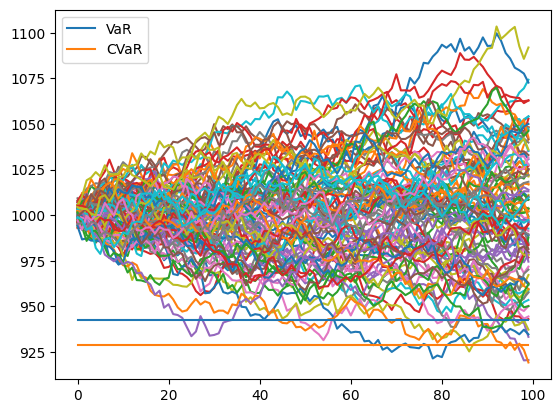

In [4]:
def VaR(returns,alpha):
  if isinstance(returns,pd.Series):
    return np.percentile(returns,alpha)
  else:
    raise TypeError("Panda TS is expected.")
def CVaR(returns,alpha,VaR_result):
  if isinstance(returns,pd.Series):
    belowVaR=returns<=VaR_result
    return returns[belowVaR].mean()
  else:
    raise TypeError("Panda TS is expected.")

alpha=5 #define significance level

portfolioResults=pd.Series(portolio_sims[-1,:])
VaR=VaR(portfolioResults,alpha)
CVaR=CVaR(portfolioResults,alpha,VaR)
print('VaR is ', format(round(VaR,2)),'Expected Shortfall is ', format(round(CVaR,2)))

VaRLine=np.full((T,1),VaR)
CVaRLine=np.full((T,1),CVaR)
plt.plot(portolio_sims)
plt.plot(VaRLine, label="VaR")
plt.plot(CVaRLine, label="CVaR")
plt.legend()